# Heart Rate Recovery Analysis

## Theory
Inability to recover heart rate to pre-exercise values may suggest sympathetic and/or
parasympathetic nervous system dysfunction.

## Purpose
Analysis of heart rate following maximal exercise testing.

## Outline
- Load heart rate data
- Clean data via filtering, time normalization, and resampling
- Apply different analytical methods

## Import Statements

In [31]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from math import exp, floor, ceil
from scipy.signal import resample
from scipy.stats import linregress

## Functions

In [2]:
def median_absolute_deviation(x):
    """
    Returns the median absolute deviation from the window's median
    :param x: Values in the window
    :return: MAD
    """
    return np.median(np.abs(x - np.median(x)))


In [3]:
def hampel(ts, window_size=5, n=3, imputation=False):
    # source: https://github.com/MichaelisTrofficus/hampel_filter
    # tremendous thanks for making this, and in effect making my life easier

    """
    Median absolute deviation (MAD) outlier in Time Series
    :param ts: a pandas Series object representing the timeseries
    :param window_size: total window size will be computed as 2*window_size + 1
    :param n: threshold, default is 3 (Pearson's rule)
    :param imputation: If set to False, then the algorithm will be used for outlier detection.
        If set to True, then the algorithm will also imput the outliers with the rolling median.
    :return: Returns the outlier indices if imputation=False and the corrected timeseries if imputation=True
    """

    if type(ts) != pd.Series:
        raise ValueError("Timeseries object must be of type pandas.Series.")

    if type(window_size) != int:
        raise ValueError("Window size must be of type integer.")
    else:
        if window_size <= 0:
            raise ValueError("Window size must be more than 0.")

    if type(n) != int:
        raise ValueError("Window size must be of type integer.")
    else:
        if n < 0:
            raise ValueError("Window size must be equal or more than 0.")

    # Copy the Series object. This will be the cleaned timeseries
    ts_cleaned = ts.copy()

    # Constant scale factor, which depends on the distribution
    # In this case, we assume normal distribution
    k = 1.4826

    rolling_ts = ts_cleaned.rolling(window_size*2, center=True)
    rolling_median = rolling_ts.median().fillna(method='bfill').fillna(method='ffill')
    rolling_sigma = k*(rolling_ts.apply(median_absolute_deviation).fillna(method='bfill').fillna(method='ffill'))

    outlier_indices = list(np.array(np.where(np.abs(ts_cleaned - rolling_median) >= (n * rolling_sigma))).flatten())

    if imputation:
        ts_cleaned[outlier_indices] = rolling_median[outlier_indices]
        return ts_cleaned

    return outlier_indices

## Preprocessing

In [5]:
def get_files() -> list:
    return [
        "L:/bucket/vo2max/2019_0361_0002_MAX_TEST.txt"
    ]

In [6]:
# load data
def load_csv2df(*, file: str, **kwargs) -> pd.DataFrame:
    return pd.read_csv(file, sep='\t', skiprows=[1], **kwargs)

In [7]:
# rename column
def rename_columns(*, df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns={'Time': 'time', 'Sel Duration': 'rri'})

In [8]:
# normalize time
def normalize_time(*, df: pd.DataFrame) -> pd.DataFrame:
    df['time'] = df['time'] - df['time'].loc[0]
    return df

In [9]:
# apply hampel filter
def apply_filter(*, df: pd.DataFrame) -> pd.DataFrame:
    df['rri_filtered'] = hampel(df['rri'], imputation=True)
    return df

In [10]:
# calculate hr
def calculate_hr(*, df: pd.DataFrame) -> pd.DataFrame:
    df['hr'] = np.divide(60, df['rri_filtered'])
    return df

In [11]:
# resample to 1 Hz
# need to do an index shift as data cannot be collected at 0s
def resample_1Hz(*, df: pd.DataFrame) -> pd.DataFrame:
    x_floor = floor(df['time'].min()) + 1
    x_ceiling = ceil(df['time'].max()) + 1

    x_array = np.linspace(x_floor, x_ceiling, x_ceiling)
    resampled_1Hz = resample(df['hr'], x_ceiling)
    df_resampled = pd.DataFrame({'time': x_array, 'hr': resampled_1Hz})
    return df_resampled.round(decimals=0)

In [12]:
# not necessary
# plot to compare original signal to resampled signal
def plot_orig_vs_resampled(*, df_orig: pd.DataFrame, df_resampled: pd.DataFrame, **kwargs) -> None:
    fig = px.scatter(df_orig, x="time", y="hr", **kwargs)
    fig.add_trace(px.scatter(df_resampled, x="time", y="hr", **kwargs))
    fig.show()

In [13]:
# filter down df to only last 120s
# recovery is always 120s
def filter_recovery_data(*, df: pd.DataFrame, n_rows: int = 120) -> pd.DataFrame:
    return df.tail(n_rows)

In [14]:
# get max value during recovery
def get_max_hr(*, df: pd.DataFrame) -> int:
    return df['hr'].max()

In [15]:
# plot recovery data
def plot_recovery_data(*, df: pd.DataFrame, **kwargs) -> None:
    fig = px.scatter(df, x="time", y="hr", **kwargs)
    fig.show()

## Curve Fitting

In [16]:
# perform linear regression
def lm(*, x: pd.DataFrame, y: pd.DataFrame, **kwargs) -> object:
    return linregress(x['time'], y['hr'], **kwargs)


In [17]:
# plot regressions
def lm_plots(*, df: pd.DataFrame, x_data_label: str = 'time', y_data_label: str = 'hr', **kwargs) -> None:
    # plot raw data
    fig = px.scatter(df, x=x_data_label, y=y_data_label, trendline='ols', **kwargs)
    fig.show()

In [19]:
# main script
files = get_files()
df = load_csv2df(file=files[0])
df = rename_columns(df=df)
df = normalize_time(df=df)
df = apply_filter(df=df)
df = calculate_hr(df=df)
df_resampled = resample_1Hz(df=df)

In [34]:
fig = go.Figure([
    go.Scatter(
        name='Raw',
        x=df['time'],
        y=df['hr'],
        mode='markers',
        marker={
            'color': 'red'
        },
        showlegend=True
    ),
    go.Scatter(
        name='Resampled',
        x=df_resampled['time'],
        y=df_resampled['hr'],
        mode='markers',
        marker={
            'color': 'blue'
        },
        showlegend=True
    )
])
fig.update_layout(
    title="VO2max Heart Rate Response",
    yaxis_title="Heart Rate (bpm)",
    xaxis_title="Time (s)"
)
fig.add_vline(
    x=df_resampled.index.max() - 120,
    line_width=3,
    line_dash="dash",
    line_color="black"
)
fig.show()

In [23]:
plot_orig_vs_resampled(df_orig=df, df_resampled=df_resampled)

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [Figure({
    'data': [{'hovertemplate': 'time=%{x}<br>hr=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.341e+03, 1.342e+03, 1.343e+03]),
              'xaxis': 'x',
              'y': array([100.,  79.,  87., ..., 130., 129., 135.]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'hr'}}}
})]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['bar', 'barpolar', 'box', 'candlestick',
                     'carpet', 'choropleth', 'choroplethmapbox',
                     'cone', 'contour', 'contourcarpet',
                     'densitymapbox', 'funnel', 'funnelarea',
                     'heatmap', 'heatmapgl', 'histogram',
                     'histogram2d', 'histogram2dcontour', 'icicle',
                     'image', 'indicator', 'isosurface', 'mesh3d',
                     'ohlc', 'parcats', 'parcoords', 'pie',
                     'pointcloud', 'sankey', 'scatter',
                     'scatter3d', 'scattercarpet', 'scattergeo',
                     'scattergl', 'scattermapbox', 'scatterpolar',
                     'scatterpolargl', 'scatterternary', 'splom',
                     'streamtube', 'sunburst', 'surface', 'table',
                     'treemap', 'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

In [22]:
# perform linear regression for 1s:60s, and 61s:120s

lm_first_60 = linregress(df_resampled['time'].head(60), df_resampled['hr'].head(60))
lm_second_60 = linregress(df_resampled['time'].tail(60), df_resampled['hr'].tail(60))

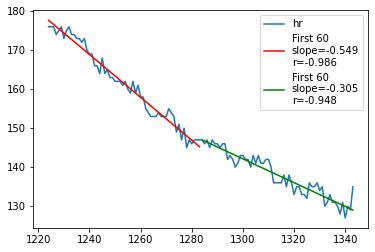

In [27]:
# plot new regressions
x_first_60 = df_resampled['time'].head(60)
y_first_60 = df_resampled['hr'].head(60)
x_second_60 = df_resampled['time'].tail(60)
y_second_60 = df_resampled['hr'].tail(60)

plt.plot(df_resampled['time'], df_resampled['hr'], label="hr")
plt.plot(
    x_first_60,
    lm_first_60.intercept + lm_first_60.slope * x_first_60,
    'r',
    label=f'First 60\nslope={round(lm_first_60.slope, 3)}\nr={round(lm_first_60.rvalue, 3)}',
)
plt.plot(
    x_second_60,
    lm_second_60.intercept + lm_second_60.slope * x_second_60,
    'g',
    label=f'First 60\nslope={round(lm_second_60.slope, 3)}\nr={round(lm_second_60.rvalue, 3)}'
)
plt.legend()
plt.show()